In [1]:
class Node:
    def __init__(self, data, depth=0, lchild=None, rchild=None):
        self.data = data
        self.depth = depth
        self.lchild = lchild
        self.rchild = rchild


class KdTree:
    def __init__(self):
        self.KdTree = None
        self.n = 0
        self.nearest = None

    def create(self, dataSet, depth=0):
        if len(dataSet) > 0:
            m, n = np.shape(dataSet)
            self.n = n - 1
            axis = depth % self.n
            mid = int(m / 2)
            dataSetcopy = sorted(dataSet, key=lambda x: x[axis])
            node = Node(dataSetcopy[mid], depth)
            if depth == 0:
                self.KdTree = node
            node.lchild = self.create(dataSetcopy[:mid], depth+1)
            node.rchild = self.create(dataSetcopy[mid+1:], depth+1)
            return node
        return None

    def preOrder(self, node):
        if node is not None:
            print(node.depth, node.data)
            self.preOrder(node.lchild)
            self.preOrder(node.rchild)

    def search(self, x, count=1):
        nearest = []
        for i in range(count):
            nearest.append([-1, None])
        self.nearest = np.array(nearest)

        def recurve(node):
            if node is not None:
                axis = node.depth % self.n
                daxis = x[axis] - node.data[axis]
                if daxis < 0:
                    recurve(node.lchild)
                else:
                    recurve(node.rchild)

                dist = sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(x, node.data)))
                for i, d in enumerate(self.nearest):
                    if d[0] < 0 or dist < d[0]:
                        self.nearest = np.insert(self.nearest, i, [dist, node], axis=0)
                        self.nearest = self.nearest[:-1]
                        break

                n = list(self.nearest[:, 0]).count(-1)
                if self.nearest[-n-1, 0] > abs(daxis):
                    if daxis < 0:
                        recurve(node.rchild)
                    else:
                        recurve(node.lchild)

        recurve(self.KdTree)

        knn = self.nearest[:, 1]
        belong = []
        return self.nearest

In [2]:
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits.axisartist.axislines as axislines
import matplotlib as mpl
from sklearn import preprocessing
min_max_scaler=preprocessing.MinMaxScaler()
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
from sklearn.model_selection import KFold
kf=KFold(n_splits=10)
def RDS(df):
    data=np.array(df)
    data2=np.array(df.drop('label',axis=1))
    rate=0.1
    dmax=[]
    for m in range(0,len(data2)-1):
        for n in range(m+1,len(data2)):
            dmax.append(sqrt(sum((data2[m] - data2[n]) ** 2 )))
    F1=[]
    for k in range(1,21):
        x1 = np.array([[1,1],[1,-1]])
        x2 = np.array([1,np.floor(k / 3)/ k])
        (Ps_,Pd_)=np.linalg.solve(x1,x2)
        H_ = -Ps_* np.log2(Ps_)-Pd_*np.log2(Pd_) #标签混合程度阈值
        temp_k=[]
        for d in range(10,11):
            a=np.percentile(dmax,d) #密度阈值
            temp_d=[]
            for train_index, test_index in kf.split(data):
                train=data[train_index]
                test=data[test_index]
                train=pd.DataFrame(train)
                train.columns=df.columns
                Dn,Dn_filted= [],[]
                noise_set=pd.DataFrame(columns=train.columns)
                label_set=list(set(train.label))
                for r in label_set:    
                    noise_set=pd.concat([noise_set,train[train.label==r].sample(frac=rate, replace=False)]) #选取噪声比例 
                train_cut=train[~train.index.isin(noise_set.index)]
                no=[]
                for j in range(0,len(noise_set)):
                    no.append(np.random.choice(label_set))
                noise_set['label2']=no
                noise_set.reset_index(drop=True,inplace=True)
                for l in range(0,len(noise_set)):  #随机替换标签
                    label_set=list(set(train.label))
                    if (noise_set.loc[l,'label']==noise_set.loc[l,'label2']):
                        label_set.remove(noise_set.loc[l,'label'])
                        noise_set.loc[l,'label2']=np.random.choice(label_set) #从剩余列表中随机选择
                noise=noise_set.drop(['label'],axis=1)
                noise.rename(columns={'label2':'label'}, inplace = True)
                train= pd.concat([train_cut,noise],axis=0,ignore_index=True) #含噪声数据集
                train_set=np.array(train)
                kdt = KdTree()
                kdt.create(train_set)  
                for x in train_set:
                    near = kdt.search(x[:-1], k+1)  # 设置临近点的个数
                    density = 0
                    t,hon,hen,dist_hon,dist_hen,DoD,DRL= 0,0,0,0,0,0,0
                    for i in range(1,k+1):
                        if x[-1] == near[i][1].data[-1]:
                            t += 1
                            hon += 1
                            dist_hon += near[i][0]
                        else:
                            hen += 1
                            dist_hen += near[i][0]
                        density += near[i][0]  #密度   

                    DoD = abs(dist_hen - dist_hon) #相异性差值(要加绝对值)
                    DRL = (hen - hon)  #标签异同差   
                    Ps = t / k
                    Pd = 1 - Ps
                    if (Ps==1)|(Ps==0):
                        H = 0
                    else:
                        H = -Ps* np.log2(Ps)-Pd*np.log2(Pd)
                  #  print('densit:',density)
                    if (density <= a): #高密度区域
                        if DRL > 0:
                            Dn.append(list(x))
                    else:
                        if (H < H_): #低密度单一标签区域
                            if DRL > 0:
                                Dn.append(list(x))
                               # print('低密度单一标签噪声')
                        else: #低密度混合标签区  
                            DoD_ = density / k
                            if DoD >= DoD_:
                                train_hon,train_hen=[],[]
                                for j in train_set:
                                    if j[-1]==x[-1]:
                                        train_hon.append(j)
                                    else:
                                        train_hen.append(j)
                                kdt_hon=KdTree()
                                kdt_hen=KdTree()
                                kdt_hon.create(train_hon)
                                kdt_hen.create(train_hen)
                                near_hon=kdt_hon.search(x,k+1)
                                near_hen=kdt_hen.search(x,k)
                                density_hon,density_hen=0,0
                                for hon in near_hon:
                                    density_hon += hon[0]
                                for hen in near_hen:
                                    density_hen += hen[0]
                                if density_hon / density_hen > 1:
                                        Dn.append(list(x))                 
                noise_neighbor=[]                   
                for e in Dn:  # 计算噪声分数
                    e=np.array(e)
                    near2=kdt.search(e[:-1],k+1) #k近邻
                    for i in range(1,k+1):
                        noise_neighbor.append(list(near2[i][1].data))
                for e in Dn:
                    e=np.array(e)
                    near3=kdt.search(e[:-1],k+1)
                    t_e=noise_neighbor.count(list(e)) #处于其它噪声近邻的次数
                    confidence_e= 1 / np.sqrt(1+t_e*t_e)#e的置信度
                    neighborhood_e=0
                    for i in range(1,k+1):
                        t_ei=noise_neighbor.count(list(near3[i][1].data))
                        confidence_ei=1 / np.sqrt(1+t_ei*t_ei) 
                        if near3[i][1].data[-1]==e[-1]:
                            different_class=-1
                        else:
                            different_class=1
                        if list(near3[i][1].data) in Dn: 
                            isnoise=1
                        else:
                            isnoise=-1
                        near4=kdt.search(near3[i][1].data[:-1],k+1)
                        n_ei=0
                        for j in range(1,k+1):
                            if list(near4[j][1].data) in Dn:
                                n_ei += 1
                        clean_ei= (k + isnoise*(n_ei- k)) / (2*k) #纯净度
                        neighborhood_e += (clean_ei*confidence_ei*different_class)/k 
                    NS_e=confidence_e * neighborhood_e #噪声得分
                    if NS_e > 0:
                        Dn_filted.append(list(e))
                noise_list=noise.values.tolist()
                TP = 0
                for c in Dn_filted:
                    if c in noise_list:
                        TP += 1
                FP = len(Dn_filted) - TP
                FN = len(noise_list) - TP
                precision= TP / (TP + FP)
                recall= TP / (TP + FN)
                f1=2 * (precision * recall) / (precision + recall)
                temp_d.append(f1) 
            for i in range(40):
                temp_k.append(np.mean(temp_d))
        F1.append(temp_k)#F1值
    return F1

In [3]:
def plot_fscore(F_score,title):
    F_source=pd.DataFrame(F_score)
    f, ax = plt.subplots(figsize=(3,2))
#cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
    h=sns.heatmap(F_source, linewidths = 0.01, ax=ax,cbar=False)
    font = {'family' : 'serif',
            'color'  : 'black',
            'weight' : 'normal',
            'size'   : 14,
            }
    cb=h.figure.colorbar(h.collections[0])
    cb.ax.tick_params(labelsize=12)#设置色标刻度字体大小
    cb.set_label('F1',fontdict=font)
    ax.set_title(title,fontsize=14,x=0.5,y=-0.5)
    ax.set_xlabel('a',fontsize=14)
    ax.set_ylabel('k',fontsize=14)
    ax.axis([0,40,0,20])
    plt.xticks([0,10,20,30,40],['0','10','20','30','40'],fontsize=12)                         
    plt.yticks([10,20],['10','20'],fontsize=12)
    plt.show()

#鸢尾花数据集

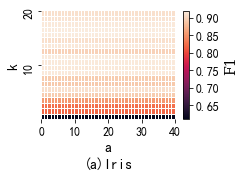

Wall time: 3min 18s


In [4]:
%%time
from sklearn.datasets import load_iris
iris = load_iris()
iris_sample= pd.DataFrame(iris.data, columns=iris.feature_names)
iris_sample['label'] = iris.target
iris_sample=iris_sample.drop_duplicates()
iris_F1=RDS(iris_sample)
plot_fscore(iris_F1,'(a)Iris')

#红酒数据集

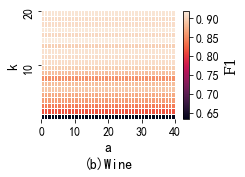

Wall time: 11min 32s


In [5]:
%%time
from sklearn.datasets import load_wine
wine= load_wine()
wine_sample = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_sample = pd.DataFrame(min_max_scaler.fit_transform(np.array(wine_sample)))
wine_sample['label'] = wine.target
wine_F1=RDS(wine_sample)
plot_fscore(wine_F1,'(b)Wine')

#种子数据集

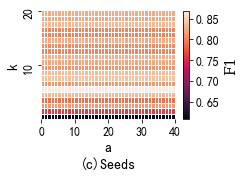

Wall time: 8min 12s


In [6]:
%%time
seeds=pd.read_csv('C:/Users/liu/python works/mydata/seeds.csv',engine='python')
seeds_sample=seeds.drop(['label'],axis=1)
seeds_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(seeds_sample)))
seeds_sample['label']=seeds.label
seeds_F1=RDS(seeds_sample)
plot_fscore(seeds_F1,'(c)Seeds')

#玻璃数据集

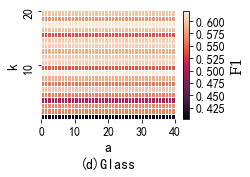

Wall time: 11min 36s


In [7]:
%%time
glass=pd.read_csv('C:/Users/liu/python works/mydata/glass.csv')
glass_sample=glass.drop(['label'],axis=1)
glass_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(glass_sample)))
glass_sample['label']=glass.label
glass_F1=RDS(glass_sample)
plot_fscore(glass_F1,'(d)Glass')

#蛋白质定位点数据集

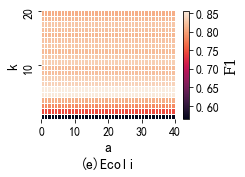

Wall time: 15min 49s


In [8]:
%%time
ecoli=pd.read_csv('C:/Users/liu/python works/mydata/ecoli.csv')
ecoli_F1=RDS(ecoli)
plot_fscore(ecoli_F1,'(e)Ecoli')

#图像分割数据集

In [ ]:
%%time
image=pd.read_csv('C:/Users/liu/python works/mydata/segmentation.csv')
image_sample=image.drop(['label'],axis=1)
image_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(image_sample)))
image_sample['label']=image.label
image_F1=RDS(image_sample)
plot_fscore(image_F1,'(f)Image')

#汽车数据集

In [ ]:
%%time
statlog=pd.read_csv('C:/Users/liu/python works/mydata/statlog.csv',engine='python')
statlog.drop_duplicates(inplace=True)
statlog_sample=statlog[['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']]
statlog_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(statlog_sample)))
statlog_sample['label']=statlog.label  
statlog_F1=RDS(statlog_sample)
plot_fscore(statlog_F1,'(g)Statlog')

#新甲状腺数据集

In [ ]:
%%time
thyroid=pd.read_csv('C:/Users/liu/python works/mydata/new-thyroid.csv',engine='python')
thyroid_sample=thyroid.drop(['label'],axis=1)
thyroid_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(thyroid_sample)))
thyroid_sample['label']=thyroid.label
thyroid_F1=RDS(thyroid_sample)
plot_fscore(thyroid_F1,'(h)Thyroid')

#酵母菌数据集

In [ ]:
%%time
yeast=pd.read_csv('C:/Users/liu/python works/mydata/yeast.csv',engine='python')
yeast_sample=yeast.drop(['label'],axis=1)
yeast_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(yeast_sample)))
yeast_sample['label']=yeast.label
yeast_F1=RDS(yeast_sample)
plot_fscore(yeast_F1,'(i)Yeast')

In [ ]:
%%time
vowel=pd.read_csv('C:/Users/liu/python works/mydata/vowel.csv',engine='python')
vowel_sample=vowel.drop(['label'],axis=1)
vowel_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(vowel_sample)))
vowel_sample['label']=vowel.label
vowel_F1=RDS(vowel_sample)
plot_Fscore(vowel_F1,'(j)Vowel')

In [ ]:
%%time
letter=pd.read_csv('C:/Users/liu/python works/mydata/letter.csv',engine='python')
letter_sample=letter.drop(['label'],axis=1)
letter_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(letter_sample)))
letter_sample['label']=letter.label
letter_F1=RDS(letter_sample)
plot_Fscore(letter_F1,'(k)Letter')

In [ ]:
%%time
pen_base=pd.read_csv('C:/Users/liu/python works/mydata/pen_base.csv',engine='python')
pen_sample=pen_base.drop(['label'],axis=1)
pen_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(pen_sample)))
pen_sample['label']=pen_base.label
pen_F1=RDS(pen_sample)
plot_Fscore(pen_F1,'(l)Pen')